In [1]:
# load Google Driver
from google.colab import drive
import sys, os
drive.mount('/content/drive')

my_path = '/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam'
sys.path.append(my_path)
os.listdir(my_path)

Mounted at /content/drive


['dataTorchTransformLoad.py',
 'Test_Train.py',
 'Plots.py',
 'Resnet.py',
 '01_CIFAR+Baseline.ipynb',
 'README.md',
 'VS_NET.py',
 '__pycache__',
 'outputs',
 'GradCam.py',
 '02_CIFAR+Resnet.ipynb']

In [2]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import sys
import random

# import for all the modular codes
import VS_NET
import Test_Train
import Plots
import dataTorchTransformLoad as dtl
import Resnet
import GradCam



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# # Modelling options for the loop


# d1 = {'NO L1&L1': [0.,0.,'model'],
#       'L1 Only': [1e-04,0.,'model'], 
#       'L2 Only': [0.,1e-04,'model'],
#       'L1&L2':[1e-04,1e-04,'model'],
#       'GBN Only': [0,0,'model2'],
#       'GBN with L1 and L2':[1e-04,1e-04,'model2']}

#initializers 
dropout_value = 0.05
num_splits=2
EPOCHS = 2
input_ch=3

metric_values = {}
models={}

batch_size_GPU=64
batch_size_CPU=16




In [4]:
# Transforms

transforms_cifar_train = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomRotation((-5.0, 5.0),fill=1), 
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                           transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])
transforms_cifar_test = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        #   transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                        #   transforms.RandomHorizontalFlip(0.3),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                          #  transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])

In [5]:
# download data

train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms_cifar_train)
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms_cifar_test) 

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=batch_size_GPU, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_CPU)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [7]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


In [9]:
# functions to show an image

def imageshow(img):
    # img = img / 2 + 0.5      #unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

[['bird' 'car' 'truck' 'truck' 'horse' 'truck' 'horse' 'cat']
 ['car' 'ship' 'truck' 'truck' 'plane' 'cat' 'bird' 'truck']
 ['plane' 'horse' 'ship' 'ship' 'frog' 'dog' 'ship' 'plane']
 ['frog' 'frog' 'horse' 'bird' 'cat' 'truck' 'ship' 'frog']
 ['car' 'horse' 'ship' 'dog' 'car' 'car' 'deer' 'cat']
 ['frog' 'car' 'dog' 'bird' 'cat' 'dog' 'horse' 'ship']
 ['dog' 'horse' 'ship' 'frog' 'frog' 'horse' 'dog' 'car']
 ['deer' 'dog' 'deer' 'car' 'ship' 'bird' 'bird' 'truck']]


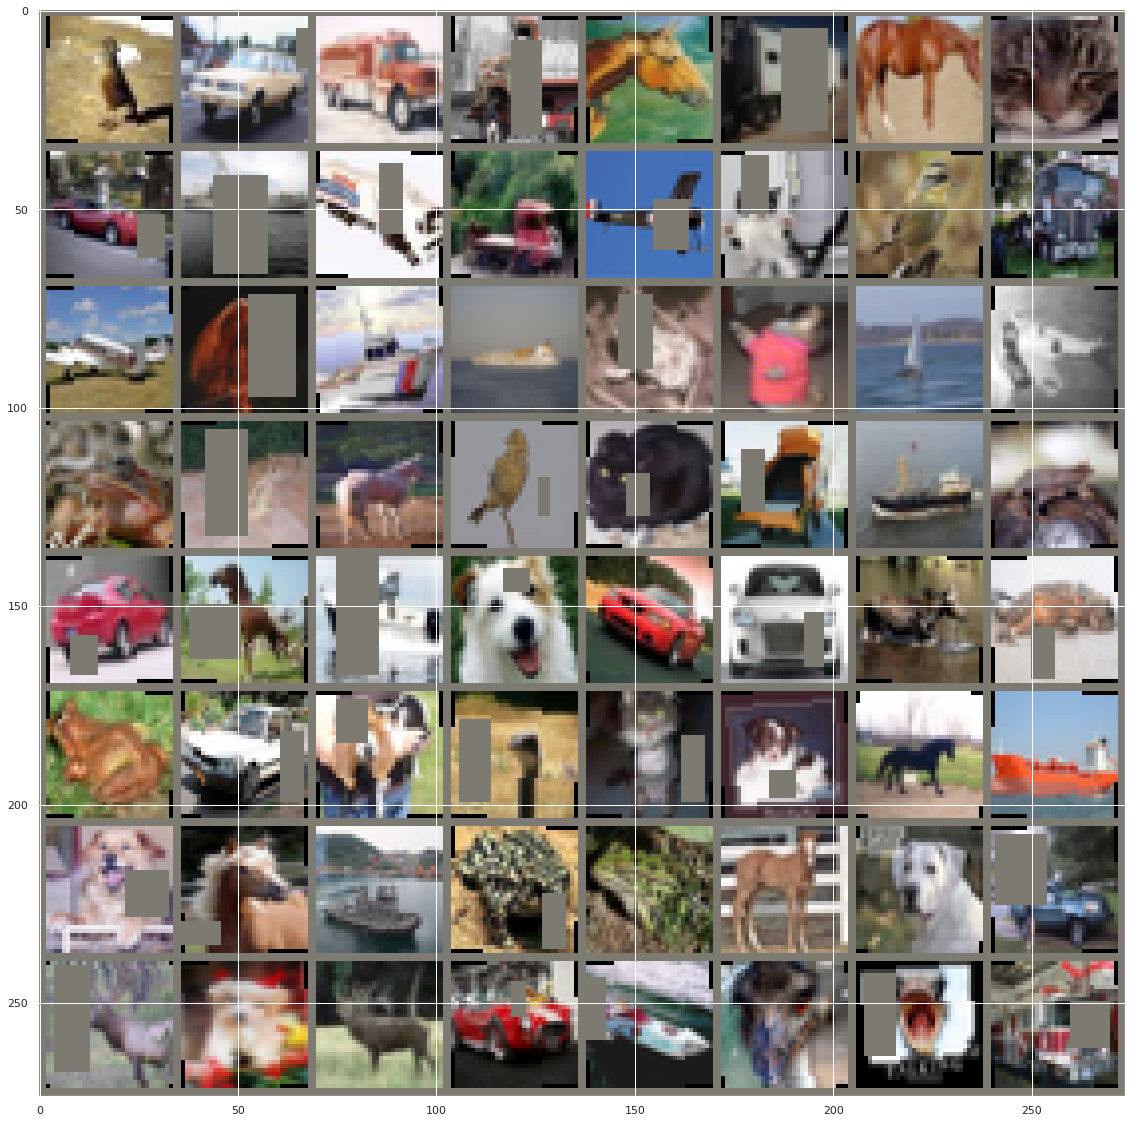

In [10]:


random.seed(1)
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
random.seed(1)
imageshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(64)))
print(np.array([classes[labels[j]] for j in range(64)]).reshape(8,8))

In [11]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    plt.imshow(image)
    plt.grid(b=None)
    return image

<Figure size 432x288 with 0 Axes>

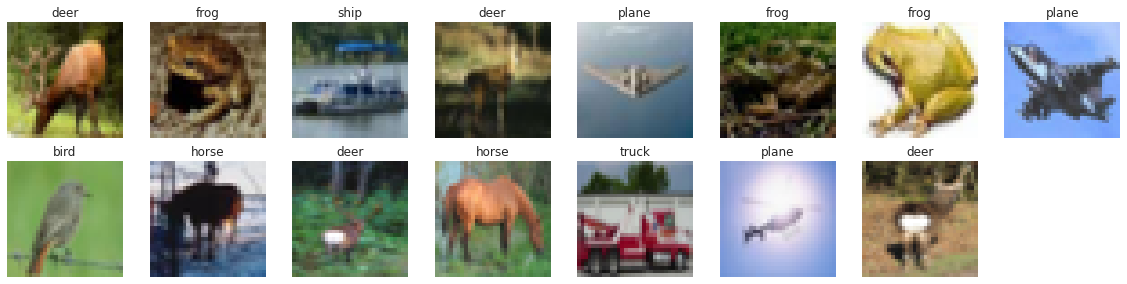

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# plt.style.use('dark_background')


figure = plt.figure()
plt.figure(figsize=(20,20))
num_of_images = 16
for index in range(1, num_of_images):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.title(classes[labels[index].item()])
    imshow(images[index])

torch.Size([3, 32, 32]) (32, 32, 3)


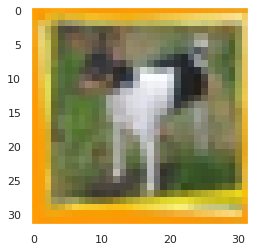

In [13]:
# imshow(images[0])
trans_ig = imshow(images[0])
print(images[0].shape, trans_ig.shape)

#RESNET

In [14]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


In [15]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

In [16]:
exp_name = 'Resnet'

trainer = Test_Train.Trainer(model,device,train_loader,test_loader,optimizer,
                             EPOCHS,scheduler)
train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=0.9763553142547607 Batch_id=781 Accuracy=48.64: 100%|██████████| 782/782 [01:08<00:00, 11.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3307, Accuracy: 5584/10000 (55.84%)

EPOCH: 1
learning rate  [0.01]


Loss=0.6614128351211548 Batch_id=781 Accuracy=66.72: 100%|██████████| 782/782 [01:07<00:00, 11.54it/s]



Test set: Average loss: 0.9131, Accuracy: 6909/10000 (69.09%)



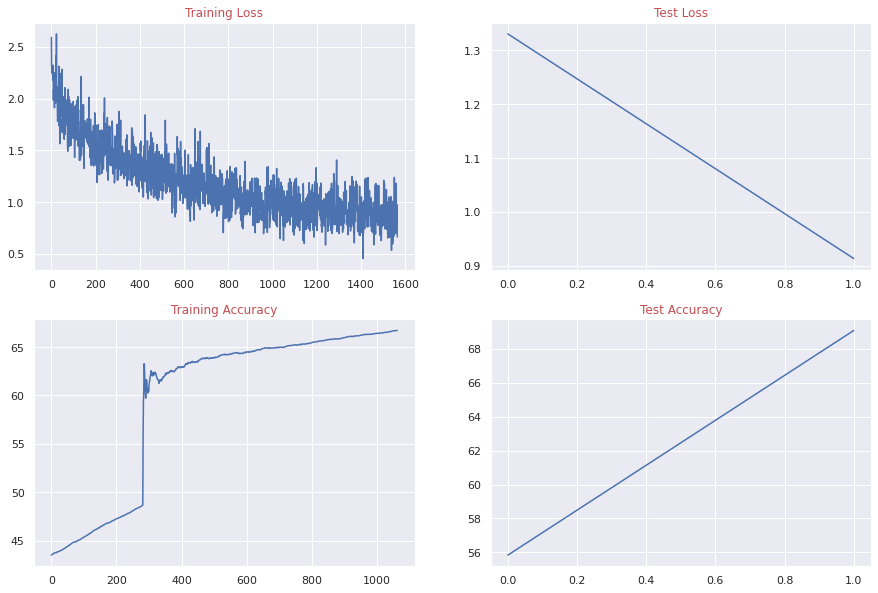

In [17]:
Plots.plot_metrics(train_metric, test_metric)

In [19]:
def im_unnormalize(img):
  # img = img / 2 + 0.5     # unnormalize
  img[0] = img[0]*0.24703223 + 0.49139968
  img[1] = img[1]*0.24348513 + 0.48215841
  img[2] = img[2]*0.26158784 + 0.44653091
  npimg = img.numpy()
  unnorm_img = np.transpose(npimg, (1, 2, 0))
  return unnorm_img

# Plot misclassified

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


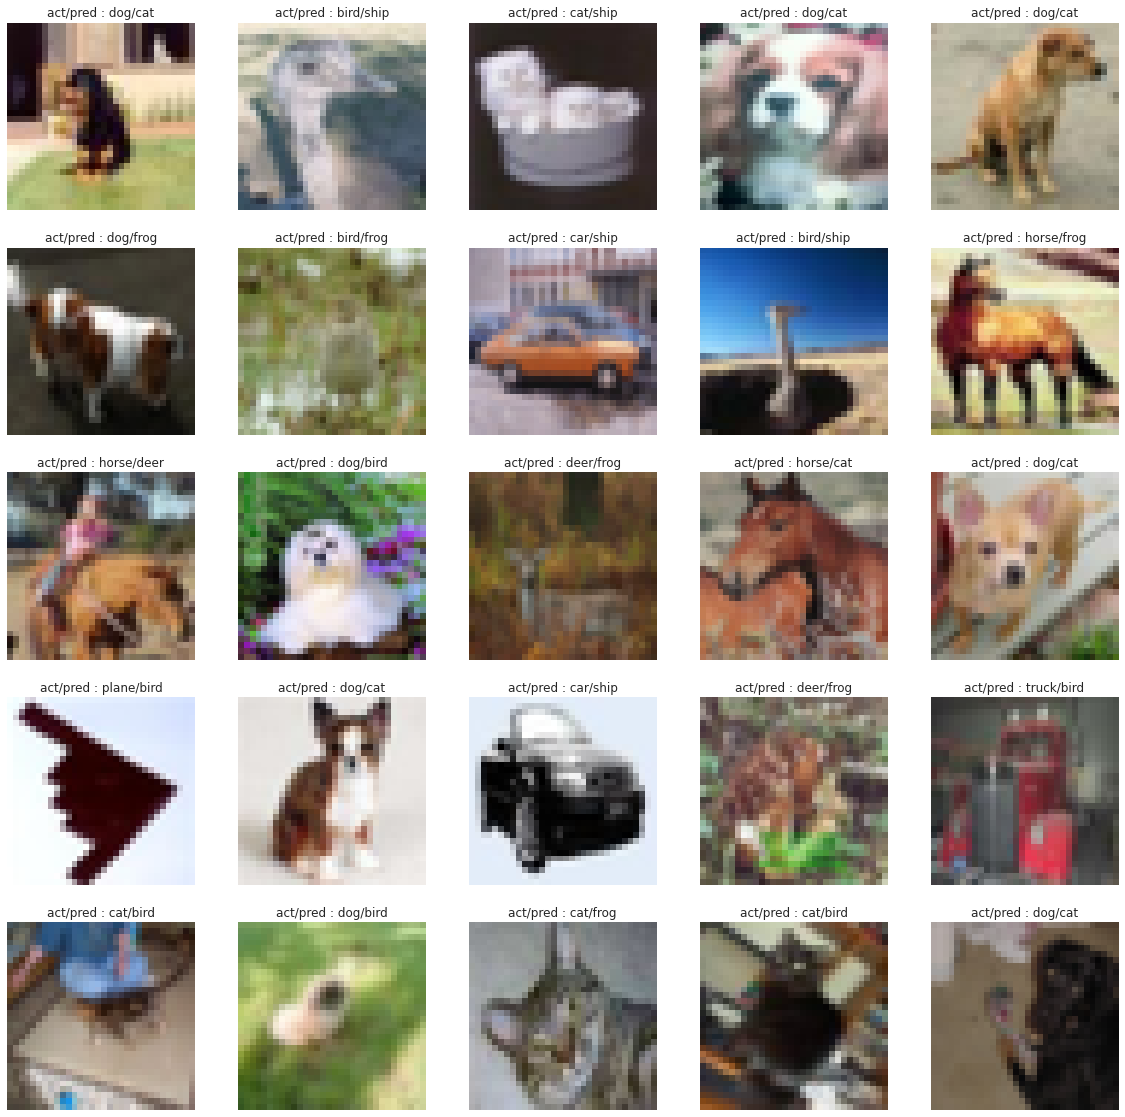

In [62]:




model.eval()

figure = plt.figure(figsize=(20, 20))
num_of_images = 25
index = 1

misclass_img_list = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.
            
                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)
                                  


                plt.title(titl)
                index += 1


# GEt one image from saved image - jpg
do the same transforms as ganapthy. 
get the grad cam


# get one data from test cifar
understand the dimensions of image that is passed if gradam works in real image
transform the cifar image


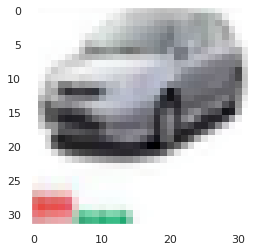

In [53]:
# dataiter = iter(test_loader)
# images, labels = dataiter.next()

# i = 5
# transformed_image1 = images[i].cpu()
# image1 = imshow(transformed_image1)
# plt.imshow(image1)
# # img_unnormalized = im_unnormalize(transformed_image1)

In [63]:
i = 1
print('name'+str(i))

name1


img1.jpeg
img2.jpeg
img3.jpeg
img4.jpeg


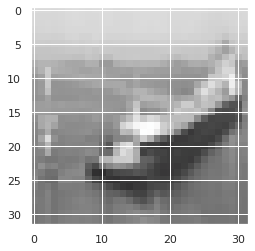

In [75]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Save image
import matplotlib
img_list = []

for i in range(4):
  img_name = 'img'+str(i+1)+'.jpeg'
  img_list.append(img_name)
  matplotlib.image.imsave(img_name, imshow(images[i].cpu()))
  print(img_name)

In [76]:
img_list

['img1.jpeg', 'img2.jpeg', 'img3.jpeg', 'img4.jpeg']

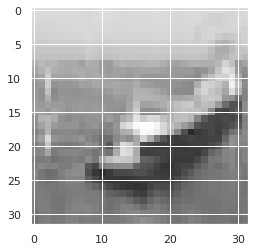

In [77]:
# Download PIL Images
import PIL
# pil_image=[]
# img_name = ['name1.jpeg','name.jpeg']
pil_image = []
for i,img in enumerate(img_list):
   img = PIL.Image.open(img)
   pil_image.append(img)
   plt.imshow(img)


In [78]:
len(pil_image)

4

In [54]:

# print(transformed_image1.shape, image1.shape)
# matplotlib.image.imsave('name1.jpeg', image1)

torch.Size([3, 32, 32]) (32, 32, 3)


In [47]:
# from PIL import Image
# im = Image.open('name.jpeg')
# plt.imshow(im)

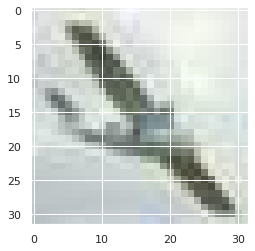

In [59]:

# # Download PIL Images
# import PIL
# # pil_image=[]
# # img_name = ['name1.jpeg','name.jpeg']
# pil_image = []
# for i,img in enumerate(img_list):
#    img = PIL.Image.open(img)
#    pil_image.append(img)
#    plt.imshow(img)



# plt.imshow(pil_image[0])
# plt.imshow(pil_image[1])

In [79]:
from torchvision import transforms
normed_torch_img = []
torch_img_list = []

for i in pil_image:
  torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])(i).to(device)
  torch_img_list.append(torch_img)
  normed_torch_img.append(transforms.Normalize([0.5, 0.5, 0.5], [0.24703223, 0.24348513, 0.26158784])(torch_img)[None])

In [80]:

def imshow1(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)
    plt.grid(b=None)


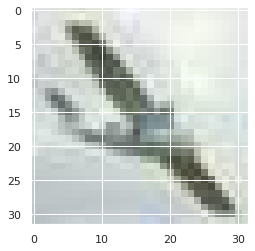

In [60]:
# for i in pil_image:
#   plt.imshow(i)

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


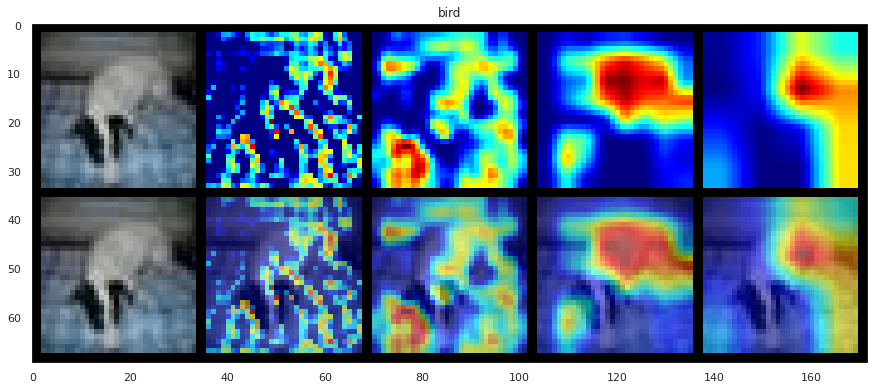

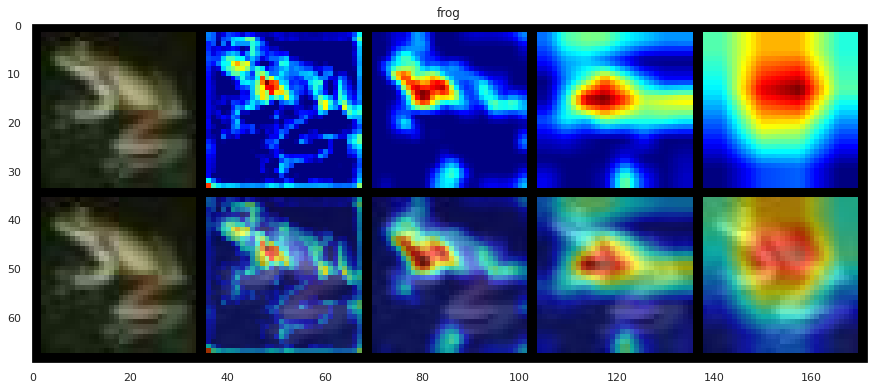

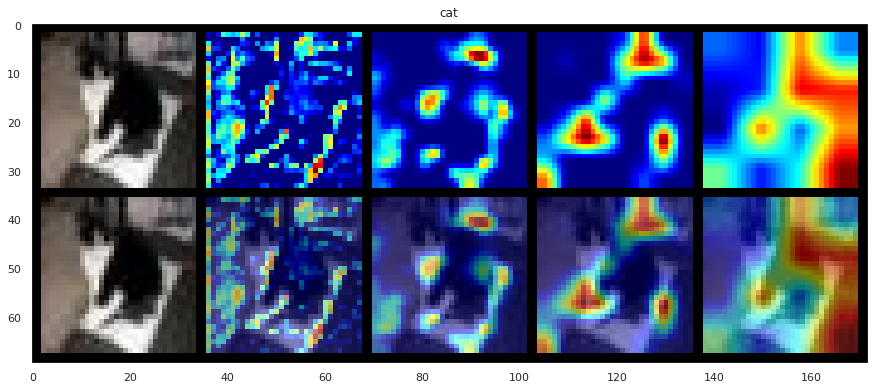

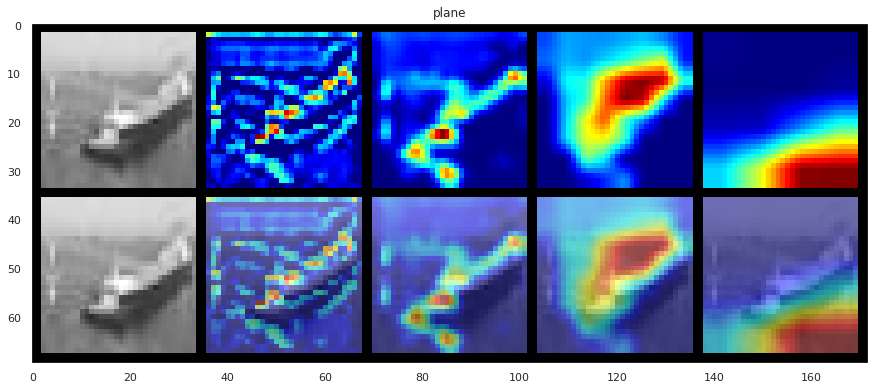

In [81]:

import copy
from torchvision.utils import make_grid, save_image

for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
    

  grid_image = make_grid(images1+images2,nrow=5,padding=2,normalize=False)

  imshow1(grid_image,c = classes[int(predicted)])

In [73]:
untrans_img[1].shape

torch.Size([3, 32, 32])

In [74]:
untrans_img[1].unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [78]:
dataiter = iter(test_loader)
images, labels = dataiter.next()


In [92]:
images = images.to(device)

In [93]:
output = model(images)

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


torch.Size([3, 32, 32]) (32, 32, 3)


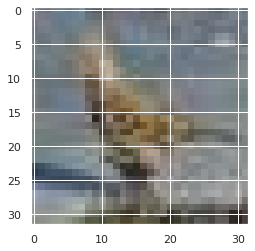

In [133]:
np.array(im).shape

(32, 32, 3)

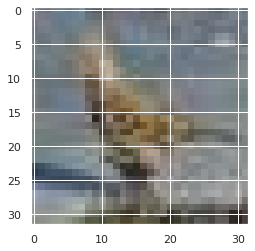

In [137]:
import PIL
pil_image=[]
img_name = ['name.jpeg','name2.jpeg']
pil_image = []
for i,img in enumerate(img_name):
   img = PIL.Image.open(img)
   pil_image.append(img)
   plt.imshow(img)

plt.imshow(pil_image[1])

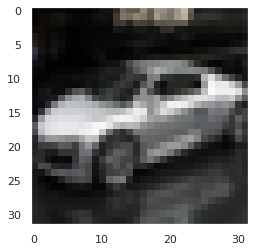

In [151]:
image_trial = imshow(images[2].cpu())

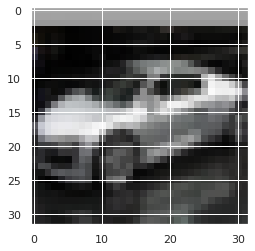

In [164]:
plt.imshow(image_trial)


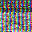

In [177]:
to_pil_image = transforms.ToPILImage('RGB')
results = to_pil_image(image_trial)
results

In [161]:


pil_img = transforms.ToPILImage('RGB')(image_trial)
plt.imshow(pil_img)

AttributeError: ignored

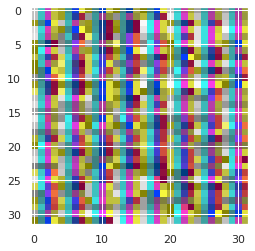

In [144]:
plt.imshow(pil_img)

In [34]:
np.array(pil_image[0]).shape

(32, 32, 3)

In [35]:
from torchvision import transforms
normed_torch_img = []
torch_img_list = []


for i in pil_image:
  torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])(i).to(device)
  torch_img_list.append(torch_img)
  normed_torch_img.append(transforms.Normalize([0.5, 0.5, 0.5], [0.24703223, 0.24348513, 0.26158784])(torch_img)[None])

In [38]:
len(torch_img_list)

torch_img_list[0].shape

torch.Size([3, 32, 32])

In [40]:
def im_unnormalize(img):
  # img = img / 2 + 0.5     # unnormalize
  img[0] = img[0]*0.24703223 + 0.49139968
  img[1] = img[1]*0.24348513 + 0.48215841
  img[2] = img[2]*0.26158784 + 0.44653091
  # npimg = img.numpy()
  # unnorm_img = np.transpose(npimg, (1, 2, 0))
  return img

## One way of doing.. Works but not that well

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

images, labels = images.to(device), labels.to(device)

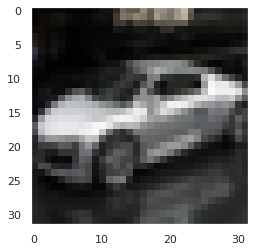

In [127]:
i = 2
transformed_image1 = images[i].cpu()
image1 = imshow(transformed_image1)
img_unnormalized = im_unnormalize(transformed_image1)


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


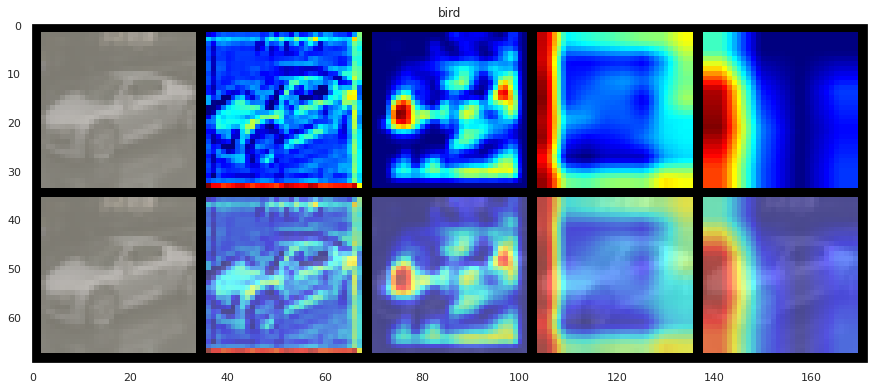

In [128]:
import copy
from torchvision.utils import make_grid, save_image


images1 = [img_unnormalized.cpu()]
images2 =  [img_unnormalized.cpu()]
b = copy.deepcopy(model.to(device))
output = model(transformed_image1.unsqueeze(0).to(device))
_, predicted = torch.max(output.data, 1)
layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
for j in layers:
  g = GradCAM(b,j)
  mask, _= g(transformed_image1.unsqueeze(0).to(device))
  heatmap, result = visualize_cam(mask,img_unnormalized )
  images1.extend([heatmap])
  images2.extend([result])

grid_image = make_grid(images1+images2,nrow=5,padding=2,normalize=False)

imshow1(grid_image,c = classes[int(predicted)])

In [54]:
trans_image[0].shape

torch.Size([3, 32, 32])

In [ ]:
images1 = [img_unnormalized.cpu()]
images2 =  [img_unnormalized.cpu()]
b = copy.deepcopy(model.to(device))
output = model(normed_torch_img[i])
_, predicted = torch.max(output.data, 1)
#print(classes[int(predicted)])
layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
for j in layers:
  g = GradCAM(b,j)
  mask, _= g(normed_torch_img[i])
  heatmap, result = visualize_cam(mask,torch_img_list[i] )
  images1.extend([heatmap])
  images2.extend([result])

grid_image = make_grid(images1+images2,nrow=5,padding=2,normalize=False)

imshow1(grid_image,c = classes[int(predicted)])

In [43]:
len(torch_img_list)

3

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


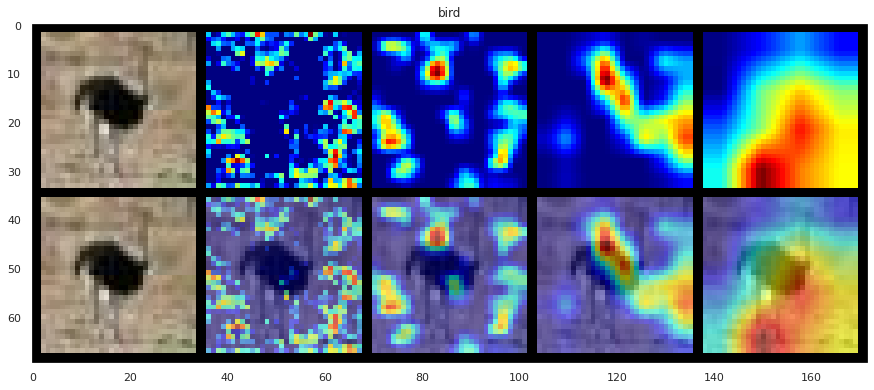

In [102]:

def imshow1(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)
    plt.grid(b=None)

import copy
from torchvision.utils import make_grid, save_image

for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])

  grid_image = make_grid(images1+images2,nrow=5,padding=2,normalize=False)

  imshow1(grid_image,c = classes[int(predicted)])

In [41]:
i=0
images1 = [torch_img_list[i].cpu()]
images2 =  [torch_img_list[i].cpu()]
b = copy.deepcopy(model.to(device))
output = model(normed_torch_img[i])
_, predicted = torch.max(output.data, 1)
#print(classes[int(predicted)])
layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
for j in layers:
  g = GradCAM(b,j)
  mask, _= g(normed_torch_img[i])
  heatmap, result = visualize_cam(mask,torch_img_list[i] )
  images1.extend([heatmap])
  images2.extend([result])

# grid_image = make_grid(images1+images2,nrow=5)
# imshow(grid_image,c = classes[int(predicted)])

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


AttributeError: ignored

In [ ]:
transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        #   transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                        #   transforms.RandomHorizontalFlip(0.3),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                          #  transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])

torch.Size([3, 32, 32]) (32, 32, 3)


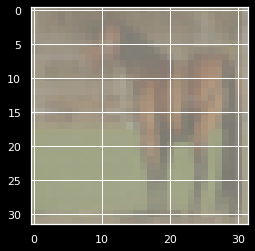

In [48]:
from torchvision import transforms
import PIL

print(untrans_image.shape, act_image.shape)



In [86]:
from torchvision import transforms
normed_torch_img = []
torch_img_list = []

for i in pil_image:
  torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])(i).to(device)
  torch_img_list.append(torch_img)
  normed_torch_img.append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(torch_img)[None])

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


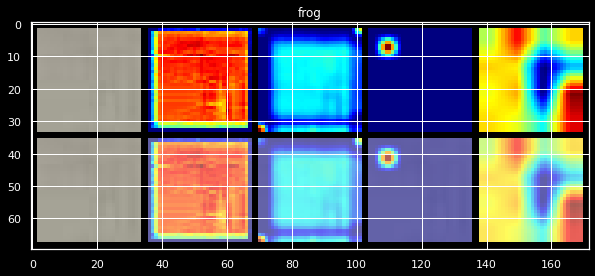

In [93]:
import copy
from torchvision.utils import make_grid, save_image
import GradCam
for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  imshow(grid_image,c = classes[int(predicted)])

In [156]:
# misclass_img_list[0].shape
len(untrans_img)

25

In [ ]:
transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        #   transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                        #   transforms.RandomHorizontalFlip(0.3),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                          #  transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])

In [145]:
# Transform the misclassified images. 



# plt.imshow(torch_img_list[0])
from PIL import Image
from matplotlib import cm

from torchvision import transforms
normed_torch_img = []
torch_img_list = []

for i in misclass_img_list:
  im = Image.fromarray(np.uint8(i)).convert('RGB') # convert array image to pil image
  torch_img = transforms.Compose([transforms.ToTensor()
  ])(im).to(device)
  torch_img_list.append(torch_img)
  normed_torch_img.append(transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])(torch_img)[None])

In [167]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  imshow(grid_image,c = classes[int(predicted)])

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


TypeError: ignored

In [27]:
# -*- coding: utf-8 -*-
"""gradcam.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/15jNC5H3pI6Dd0UMS9fcREpMcMB7F9ljl
"""

import torch
import torch.nn.functional as F
import cv2

class GradCAM:
    """Calculate GradCAM salinecy map.
    Args:
        input: input image with shape of (1, 3, H, W)
        class_idx (int): class index for calculating GradCAM.
                If not specified, the class index that makes the highest model prediction score will be used.
    Return:
        mask: saliency map of the same spatial dimension with input
        logit: model output
    A simple example:
        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        gradcam = GradCAM.from_config(model_type='resnet', arch=resnet, layer_name='layer4')
        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)
        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)
        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)
    """

    def __init__(self, model, layer_name):
        self.model = model
        # self.layer_name = layer_name
        self.target_layer = layer_name

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    @classmethod
    def from_config(cls, arch: torch.nn.Module, model_type: str, layer_name: str):
        target_layer = layer_finders[model_type](arch, layer_name)
        return cls(arch, target_layer)

    def saliency_map_size(self, *input_size):
        device = next(self.model_arch.parameters()).device
        self.model(torch.zeros(1, 3, *input_size, device=device))
        return self.activations['value'].shape[2:]

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
        
        self.gradients.clear()
        self.activations.clear()
        return saliency_map, logit
    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

"""VISUALIZE_GRADCAM"""

def visualize_cam(mask, img, alpha=1.0):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result

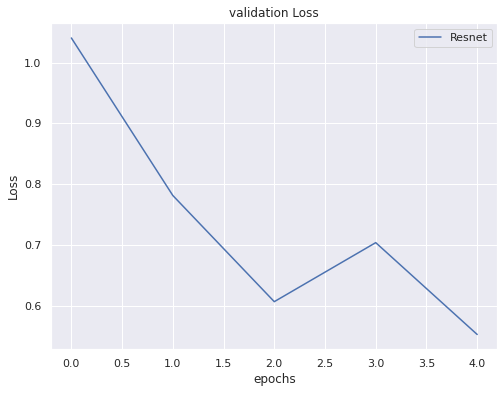

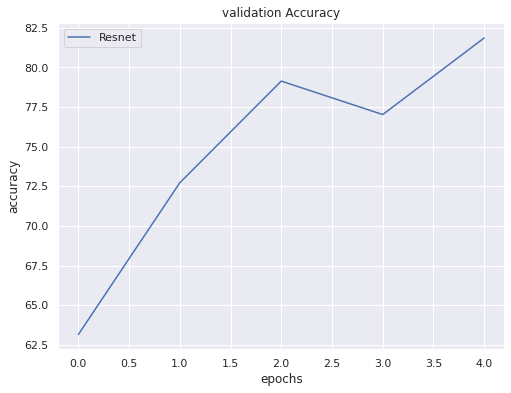

In [14]:
Plots.multi_plots_loss(metric_values)
Plots.multi_plots_acc(metric_values)

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/09_Data-Augmentation & Gradcam/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


TypeError: ignored

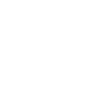

In [15]:
# plot_misclassified(model2,test_loader,device)

Plots.plot_misclassified(model,test_loader,device)